# In-Context Learning Model Evaluation

Comprehensive evaluation notebook for trained transformer models on linear regression tasks.

**Features:**
- Load trained models from checkpoint
- Full evaluation suite with multiple test scenarios
- Baseline comparisons (OLS, k-NN, Averaging)
- Visualization of in-context learning curves
- Out-of-distribution robustness tests (random quadrants, orthogonal, scaling)
- Works with qwen2.5, GPT-2, and LSTM models
- **NEW:** Shows both raw and normalized metrics for easier comparison

**Prerequisites:**
- A trained model checkpoint (from train_colab.ipynb)
- Model's run_id and output directory

**About Normalization:**
This notebook shows metrics in two formats:
- **Raw**: Actual squared error values
- **Normalized**: Raw values divided by `n_dims` (dimension count)

Normalization makes it easier to compare performance across different problem dimensions, since the baseline "zero estimator" (always predicting 0) has expected squared error = `n_dims`.

## 1. Check GPU and Environment


In [1]:
# Check GPU availability
!nvidia-smi

import sys
print(f"\nPython version: {sys.version}")


Wed Nov 19 19:09:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   43C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Install Required Packages


In [2]:
print("Installing packages...\n")

# Core ML packages
%pip install -q transformers>=4.30.0
%pip install -q xgboost
%pip install -q matplotlib seaborn tqdm pandas
%pip install -q pyyaml
%pip install -q munch
%pip install -q scikit-learn

# PyTorch usually comes pre-installed in Colab
try:
    import torch
    print(f"✓ PyTorch already installed: {torch.__version__}")
except ImportError:
    print("Installing PyTorch...")
    %pip install -q torch torchvision torchaudio

print("\n" + "="*60)
print("✓ All required packages installed successfully!")
print("="*60)

# Verify key packages
import torch
import transformers
import yaml
import matplotlib.pyplot as plt
import numpy as np

print(f"\nPackage Versions:")
print(f"  PyTorch: {torch.__version__}")
print(f"  Transformers: {transformers.__version__}")

print(f"\nGPU Information:")
print(f"  CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  CUDA version: {torch.version.cuda}")
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("  ⚠️  No GPU detected! Enable GPU: Runtime → Change runtime type → T4 GPU")

print("\n✓ Ready for evaluation!")


Installing packages...

✓ PyTorch already installed: 2.8.0+cu126

✓ All required packages installed successfully!

Package Versions:
  PyTorch: 2.8.0+cu126
  Transformers: 4.57.1

GPU Information:
  CUDA available: True
  CUDA version: 12.6
  GPU: NVIDIA L4
  GPU Memory: 23.80 GB

✓ Ready for evaluation!


## 3. Mount Google Drive (if using Drive for storage)


In [3]:
# Option 1: If your model is stored in Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/in-context-learning

# Option 2: If using repository clone (uncomment if needed)
# import os
# import subprocess
# REPO_URL = "https://github.com/hingma/in-context-learning.git"  # UPDATE THIS!
# if not os.path.exists("in-context-learning"):
#     print(f"Cloning repository from {REPO_URL}...")
#     subprocess.run(["git", "clone", REPO_URL], check=True)
#     print("✓ Repository cloned successfully")
# %cd in-context-learning


Mounted at /content/drive
/content/drive/MyDrive/in-context-learning


## 4. Import Evaluation Modules


In [4]:
# Add src to path
import sys
import os
sys.path.insert(0, './src')

# Import required modules
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
from munch import Munch

# Import project modules
from eval import (
    get_model_from_run,
    get_run_metrics,
    eval_model,
    build_evals,
    baseline_names
)
from models import build_model, get_relevant_baselines
from tasks import get_task_sampler
from samplers import get_data_sampler
from plot_utils import *

# Set plot style (matching eval.ipynb)
sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

print("✓ All modules imported successfully")


✓ All modules imported successfully


## 5. Load Trained Model

**IMPORTANT:** Update the `run_id` below with your trained model's run ID from training.


In [5]:
# ========================================
# UPDATE THIS WITH YOUR RUN ID!
# ========================================
run_id = "pretrained-qwen-linear"  # Replace with your run_id from training
# ========================================

run_path = os.path.join("./outputs", run_id)

# Check if model exists
if not os.path.exists(run_path):
    raise FileNotFoundError(f"Model not found at {run_path}. Please check your run_id!")

print(f"Loading model from: {run_path}\n")

# Load model and config
model, conf = get_model_from_run(run_path, step=-1)  # step=-1 loads final checkpoint

# Move model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()
    print(f"✓ Model loaded on GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️  Running on CPU (slower)")

model.eval()

# Display model configuration
print(f"\n{'='*60}")
print("Model Configuration:")
print(f"{'='*60}")
print(f"  Model Family: {conf.model.family}")
print(f"  Task: {conf.training.task}")
print(f"  n_dims: {conf.model.n_dims}")
print(f"  n_positions: {conf.model.n_positions}")
print(f"  n_embd: {conf.model.n_embd}")
print(f"  n_layer: {conf.model.n_layer}")
print(f"  n_head: {conf.model.n_head}")
print(f"  Training points: {conf.training.curriculum.points.end}")
print(f"{'='*60}")
print(f"\n✓ Model ready for evaluation")


Loading model from: ./outputs/pretrained-qwen-linear

✓ Model loaded on GPU: NVIDIA L4

Model Configuration:
  Model Family: qwen2.5
  Task: linear_regression
  n_dims: 20
  n_positions: 256
  n_embd: 256
  n_layer: 12
  n_head: 8
  Training points: 41

✓ Model ready for evaluation


## 6. Quick Test Evaluation

directly load the model and measure its in-context learning ability on a batch of random inputs


In [6]:
# Setup evaluation parameters from config
n_dims = conf.model.n_dims
n_points = conf.training.curriculum.points.end
batch_size = 64
task_name = conf.training.task
data_name = conf.training.data

# Create data and task samplers
data_sampler = get_data_sampler(data_name, n_dims=n_dims)
task_sampler = get_task_sampler(task_name, n_dims, batch_size)

print(f"Evaluation Setup:")
print(f"  Task: {task_name}")
print(f"  Data: {data_name}")
print(f"  n_dims: {n_dims}")
print(f"  n_points: {n_points}")
print(f"  batch_size: {batch_size}")

# Generate test data
task = task_sampler()
xs = data_sampler.sample_xs(n_points, batch_size)
ys = task.evaluate(xs)

print(f"\nGenerated test data:")
print(f"  xs shape: {xs.shape}  (batch_size, n_points, n_dims)")
print(f"  ys shape: {ys.shape}  (batch_size, n_points)")

# Get model predictions
device = "cuda" if torch.cuda.is_available() and model.name.split("_")[0] in ["gpt2", "qwen2.5", "lstm"] else "cpu"
with torch.no_grad():
    pred = model(xs.to(device), ys.to(device))
    pred = pred.cpu()

print(f"  pred shape: {pred.shape}")

# Compute loss
metric = task.get_metric()
loss = metric(pred, ys).numpy()

print(f"\n{'='*60}")
print("Quick Test Results:")
print(f"{'='*60}")
print(f"  Mean loss (all points): {loss.mean():.4f}")
print(f"  First point mean loss: {loss[:, 0].mean():.4f}")
print(f"  Final point mean loss: {loss[:, -1].mean():.4f}")
print(f"  Baseline (zero estimator): {n_dims:.4f}")
print(f"  Improvement: {(1 - loss[:, -1].mean() / n_dims) * 100:.1f}%")
print(f"{'='*60}")
print(f"\n✓ Quick evaluation complete")


Evaluation Setup:
  Task: linear_regression
  Data: gaussian
  n_dims: 20
  n_points: 41
  batch_size: 64

Generated test data:
  xs shape: torch.Size([64, 41, 20])  (batch_size, n_points, n_dims)
  ys shape: torch.Size([64, 41])  (batch_size, n_points)
  pred shape: torch.Size([64, 41])

Quick Test Results:
  Mean loss (all points): 5.9395
  First point mean loss: 22.1096
  Final point mean loss: 0.1824
  Baseline (zero estimator): 20.0000
  Improvement: 99.1%

✓ Quick evaluation complete


## 7. Visualize In-Context Learning Curve

Visualize how the model's performance improves with more in-context examples.

**Note:** Values are shown both raw and normalized by n_dims (=20) for easier comparison to baselines.


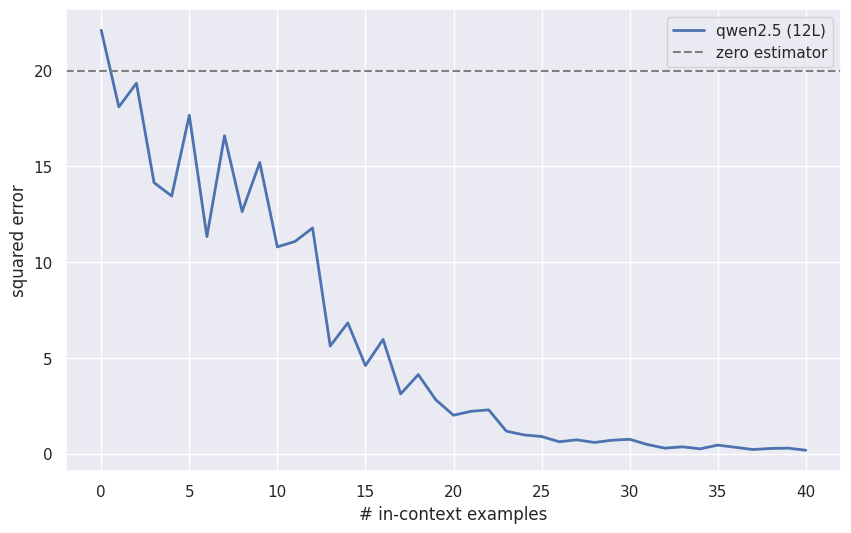


Learning Curve Statistics:
Baseline (zero estimator):    20.0000 (raw)  |  1.0000 (normalized)
Initial loss (1 example):     22.1096 (raw)  |  1.1055 (normalized)
Final loss (41 examples):    0.1824 (raw)  |  0.0091 (normalized)
Improvement over baseline: 99.1%
Total improvement (first to last): 99.2%

Normalization factor (n_dims): 20


In [ ]:
# ========================================
# Load and evaluate GPT-2 model
# ========================================
gpt2_run_id = "pretrained-gpt2-linear"
gpt2_run_path = os.path.join("./outputs", gpt2_run_id)

if os.path.exists(gpt2_run_path):
    print(f"Loading GPT-2 model from: {gpt2_run_path}\n")
    
    # Load GPT-2 model and config
    gpt2_model, gpt2_conf = get_model_from_run(gpt2_run_path, step=-1)
    
    # Move to GPU if available
    if torch.cuda.is_available():
        gpt2_model = gpt2_model.cuda()
    
    gpt2_model.eval()
    
    # Generate test data for GPT-2 (use same task and data samplers)
    gpt2_xs = data_sampler.sample_xs(n_points, batch_size)
    gpt2_ys = task.evaluate(gpt2_xs)
    
    # Get GPT-2 predictions
    device = "cuda" if torch.cuda.is_available() else "cpu"
    with torch.no_grad():
        gpt2_pred = gpt2_model(gpt2_xs.to(device), gpt2_ys.to(device))
        gpt2_pred = gpt2_pred.cpu()
    
    # Compute GPT-2 loss
    gpt2_loss = metric(gpt2_pred, gpt2_ys).numpy()
    gpt2_mean_loss = gpt2_loss.mean(axis=0)
    
    print(f"✓ GPT-2 model evaluated successfully")
    has_gpt2 = True
else:
    print(f"⚠️  GPT-2 model not found at {gpt2_run_path}")
    print("Continuing with only the current model...\n")
    has_gpt2 = False


In [ ]:

# ========================================
# Plot learning curves for both models
# ========================================
plt.figure(figsize=(10, 6))

# Calculate mean and normalization
mean_loss = loss.mean(axis=0)
normalization = n_dims  # Normalize by dimension for fair comparison

# Plot current model performance
plt.plot(mean_loss, lw=2, label=f"{conf.model.family} ({conf.model.n_layer}L)")

# Plot GPT-2 if available
if has_gpt2:
    plt.plot(gpt2_mean_loss, lw=2, label=f"GPT-2 ({gpt2_conf.model.n_layer}L)")

# Add baseline
plt.axhline(n_dims, ls="--", color="gray", label="zero estimator")

# Formatting
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()

plt.savefig(os.path.join("eval_figure","test_learning_curve.pdf"))
plt.show()

# Print summary statistics (with both raw and normalized values)
print(f"\n{'='*80}")
print("Learning Curve Statistics:")
print(f"{'='*80}")
print(f"\n{conf.model.family.upper()} Model:")
print(f"  Initial loss (1 example):     {mean_loss[0]:.4f} (raw)  |  {mean_loss[0]/normalization:.4f} (normalized)")
print(f"  Final loss ({n_points} examples):    {mean_loss[-1]:.4f} (raw)  |  {mean_loss[-1]/normalization:.4f} (normalized)")
print(f"  Improvement over baseline: {(1 - mean_loss[-1] / n_dims) * 100:.1f}%")
print(f"  Total improvement (first to last): {(1 - mean_loss[-1] / mean_loss[0]) * 100:.1f}%")

if has_gpt2:
    print(f"\nGPT-2 Model:")
    print(f"  Initial loss (1 example):     {gpt2_mean_loss[0]:.4f} (raw)  |  {gpt2_mean_loss[0]/normalization:.4f} (normalized)")
    print(f"  Final loss ({n_points} examples):    {gpt2_mean_loss[-1]:.4f} (raw)  |  {gpt2_mean_loss[-1]/normalization:.4f} (normalized)")
    print(f"  Improvement over baseline: {(1 - gpt2_mean_loss[-1] / n_dims) * 100:.1f}%")
    print(f"  Total improvement (first to last): {(1 - gpt2_mean_loss[-1] / gpt2_mean_loss[0]) * 100:.1f}%")

print(f"\nBaseline (zero estimator):    {n_dims:.4f} (raw)  |  {n_dims/normalization:.4f} (normalized)")
print(f"Normalization factor (n_dims): {normalization}")
print(f"{'='*80}")


## 8. Comprehensive Evaluation with Baselines

Run full evaluation suite including baseline comparisons. This may take a few minutes.

**Reminder:** Results will be shown in both raw and normalized formats for easier comparison with literature.


In [14]:
# Load metrics directly from cached metrics.json
metrics_path = os.path.join(run_path, 'metrics.json')
print(f"Loading metrics from: {metrics_path}")

with open(metrics_path, 'r') as f:
    all_metrics = json.load(f)

# Convert to Munch for easier access (optional, but consistent with original behavior)
all_metrics = Munch(all_metrics)

print(f"\n✓ Metrics loaded successfully!")
print(f"  Loaded from: {metrics_path}")


Loading metrics from: ./outputs/pretrained-qwen-linear/metrics.json

✓ Metrics loaded successfully!
  Loaded from: ./outputs/pretrained-qwen-linear/metrics.json


## 9. Compare with Baseline Methods

Visualize how your model compares to traditional baseline methods.

This section shows both raw squared errors and normalized values (÷ n_dims).


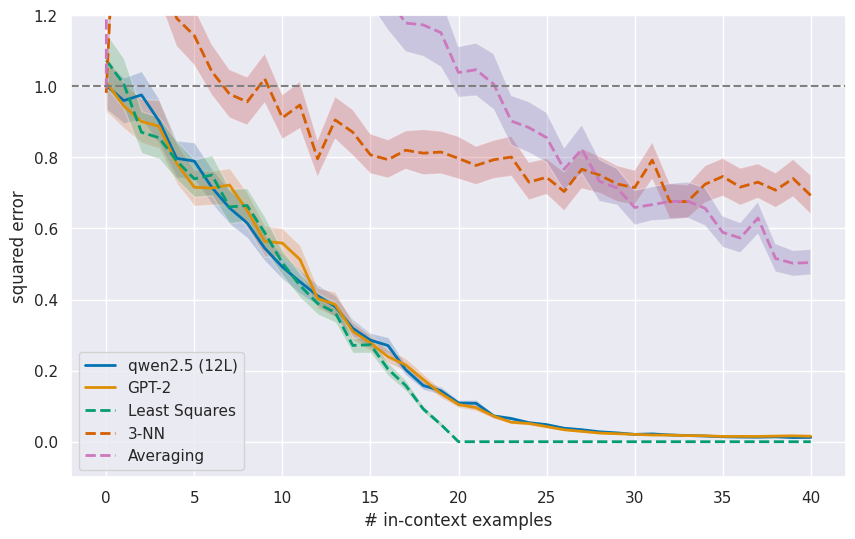


PERFORMANCE COMPARISON (Final Point Loss)
Method                                   Raw Loss        Normalized      vs Baseline    
----------------------------------------------------------------------------------------------------
QWEN2.5 (Our Model)                      0.2405          0.0120                 +98.8%
Least Squares                            0.0000          0.0000                +100.0%
3-Nearest Neighbors                      13.8574         0.6929                 +30.7%
Averaging                                10.0860         0.5043                 +49.6%
gpt2_embd=256_layer=12_head=8            0.3080          0.0154                 +98.5%
----------------------------------------------------------------------------------------------------
Baseline (Zero estimator)                20.0000         1.0000                     0.0%

Note: Normalized values divide raw loss by n_dims (20) for easier comparison.


In [15]:
# Extract standard evaluation results
standard_metrics = all_metrics.get("standard", {})

if not standard_metrics:
    print("No standard metrics found!")
else:
    # Create comparison plot (matching eval.ipynb style)
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define model name
    model_name = model.name
    # Normalization
    n_dims = model.n_dims
    normalization = n_dims

    # Plot model performance with colorblind-friendly palette
    colors = sns.color_palette('colorblind')

    # Plot model performance
    if model_name in standard_metrics:
        # print(model_name)
        # means = standard_metrics[model_name]["mean"]
        means = [m / normalization for m in standard_metrics[model_name]["mean"]]
        ax.plot(means, lw=2, label=f"{conf.model.family} ({conf.model.n_layer}L)",
                color=colors[0])
        low = [m / normalization for m in standard_metrics[model_name]["bootstrap_low"]]
        high = [m / normalization for m in standard_metrics[model_name]["bootstrap_high"]]
        ax.fill_between(range(len(low)), low, high, alpha=0.3)

    # Plot baseline models
    baseline_keys = ['gpt2_embd=256_layer=12_head=8', 'OLS_driver=None', 'NN_n=3_uniform', 'averaging']
    baseline_labels_map = {
        'OLS_driver=None': 'Least Squares',
        'NN_n=3_uniform': '3-NN',
        'averaging': 'Averaging',
        'gpt2_embd=256_layer=12_head=8': 'GPT-2'
    }

    for idx, baseline_key in enumerate(baseline_keys, 1):
        if baseline_key in standard_metrics:
            # means = standard_metrics[baseline_key]["mean"]
            means = [m / normalization for m in standard_metrics[baseline_key]["mean"]]
            label = baseline_labels_map.get(baseline_key, baseline_key)
            if label == 'GPT-2':
                ax.plot(means, lw=2, label=label, color=colors[idx])
            else:
                ax.plot(means, lw=2, label=label, linestyle='--', color=colors[idx])
            #
            low = [m / normalization for m in standard_metrics[baseline_key]["bootstrap_low"]]
            high = [m / normalization for m in standard_metrics[baseline_key]["bootstrap_high"]]
            ax.fill_between(range(len(low)), low, high, alpha=0.3)

    #
    trivial = 1.0
    ax.axhline(trivial, ls="--", color="gray")
    # Formatting
    ax.set_xlabel("# in-context examples")
    ax.set_ylabel("squared error")
    ax.legend()
    ax.set_ylim(-.1, 1.2)


    plt.savefig(os.path.join("eval_figure","comparison.pdf"))
    plt.show()

    # Print comparison table with normalized values

    print(f"\n{'='*100}")
    print("PERFORMANCE COMPARISON (Final Point Loss)")
    print(f"{'='*100}")
    print(f"{'Method':<40} {'Raw Loss':<15} {'Normalized':<15} {'vs Baseline':<15}")
    print(f"{'-'*100}")

    baseline_loss = model.n_dims  # Zero estimator

    for method_name, metrics in standard_metrics.items():
        final_loss = metrics["mean"][-1]
        normalized_loss = final_loss / normalization
        improvement = (1 - final_loss / baseline_loss) * 100

        # Clean up method name
        if method_name == model_name:
            display_name = f"{conf.model.family.upper()} (Our Model)"
        else:
            display_name = baseline_names(method_name)

        print(f"{display_name:<40} {final_loss:<15.4f} {normalized_loss:<15.4f} {improvement:>+12.1f}%")

    print(f"{'-'*100}")
    print(f"{'Baseline (Zero estimator)':<40} {baseline_loss:<15.4f} {baseline_loss/normalization:<15.4f} {'0.0%':>15}")
    print(f"{'='*100}")
    print(f"\nNote: Normalized values divide raw loss by n_dims ({normalization}) for easier comparison.")


## 10. Out-of-Distribution Robustness Tests

Evaluate model performance on various out-of-distribution scenarios.

**Note:** Plots show raw values, but the summary below includes normalized comparisons.


Plotting OOD scenarios (each with baseline comparisons):



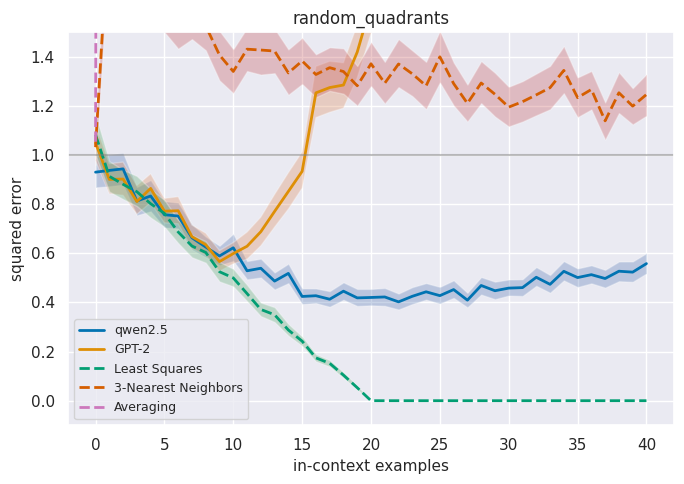

  ✓ random_quadrants: y-range [0.00, 22.83]


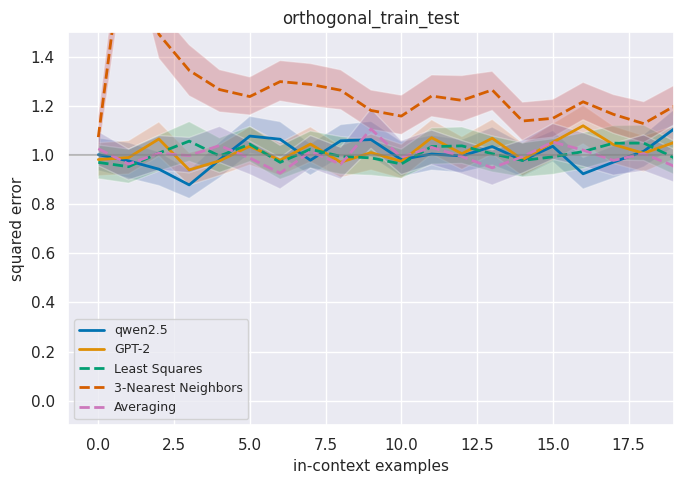

  ✓ orthogonal_train_test: y-range [0.00, 2.02]


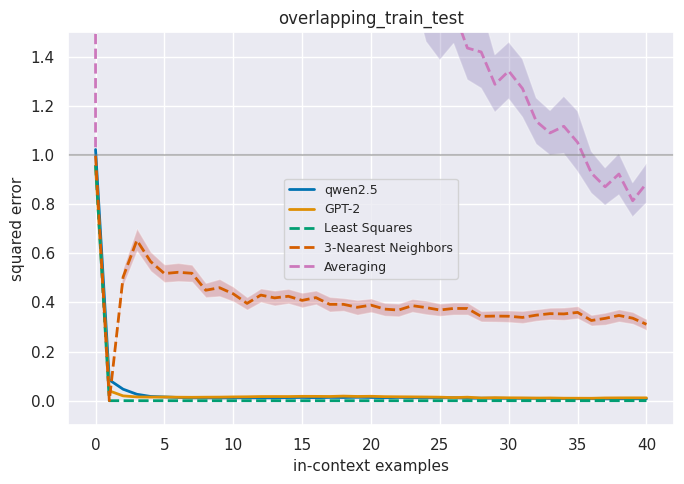

  ✓ overlapping_train_test: y-range [0.00, 497.34]


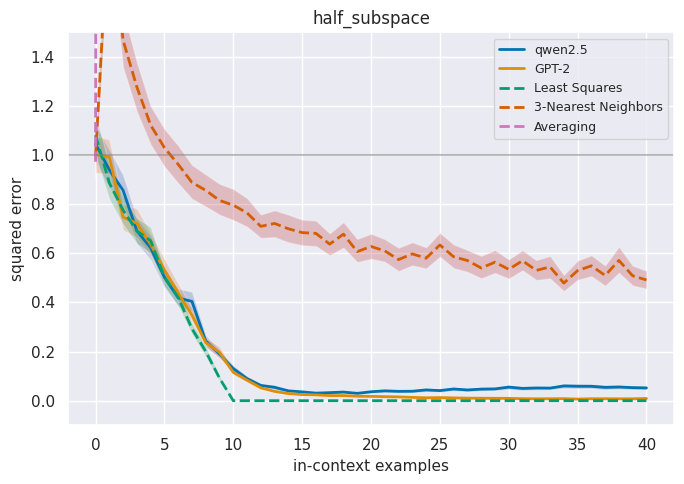

  ✓ half_subspace: y-range [0.00, 40.80]


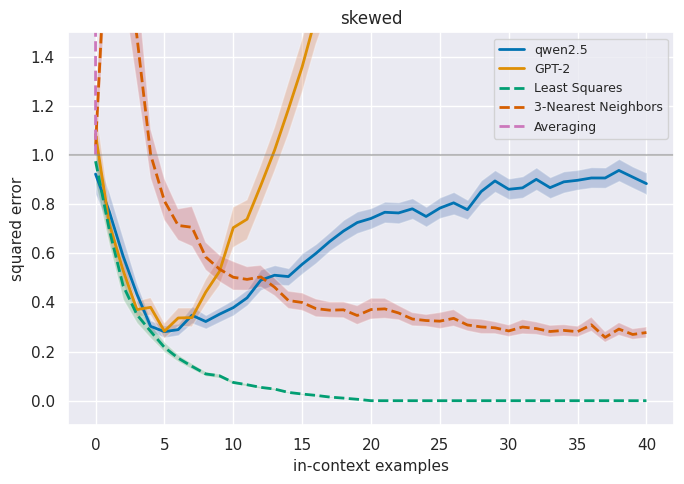

  ✓ skewed: y-range [0.00, 346.44]

Note: Axis limits are automatically adjusted based on actual data ranges.

OOD ROBUSTNESS SUMMARY (with Normalized Values)
Scenario                            Raw Loss        Normalized      vs Standard          Status         
--------------------------------------------------------------------------------------------------------------


In [16]:
# Plot OOD scenarios individually with data-driven axis limits
# This creates separate plots for each scenario with appropriate scaling

n_dims = model.n_dims
normalization = n_dims

ood_scenarios = [
    'random_quadrants',
    'orthogonal_train_test',
    'overlapping_train_test',
    'half_subspace',
    'skewed'
]

model_name = model.name
colors = sns.color_palette('colorblind')

# Baseline methods to include
baseline_keys = ['gpt2_embd=256_layer=12_head=8', 'OLS_driver=None', 'NN_n=3_uniform', 'averaging']
baseline_labels_map = {
    'OLS_driver=None': 'Least Squares',
    'averaging': 'Averaging',
    'NN_n=3_uniform': '3-Nearest Neighbors',
    'gpt2_embd=256_layer=12_head=8': 'GPT-2'
}

print("Plotting OOD scenarios (each with baseline comparisons):\n")

for scenario in ood_scenarios:
    if scenario not in all_metrics:
        continue

    metric = all_metrics[scenario]

    # Determine scale factor for axis limits
    if "scale" in scenario:
        scale = float(scenario.split("=")[-1])**2
    else:
        scale = 1.0

    # Create plot with adaptive size based on data range
    fig, ax = plt.subplots(figsize=(7, 5))

    # Collect all values to determine proper axis limits
    all_values = []

    # Plot model performance
    if model_name in metric:
        # means = metric[model_name]["mean"]
        means = [m / normalization for m in metric[model_name]["mean"]]
        ax.plot(means, lw=2, label=f"{conf.model.family}", color=colors[0])
        low = [m / normalization for m in metric[model_name]["bootstrap_low"]]
        high = [m / normalization for m in metric[model_name]["bootstrap_high"]]
        ax.fill_between(range(len(low)), low, high, alpha=0.3)

        all_values.extend(means)

    # Plot baselines
    for idx, baseline_key in enumerate(baseline_keys, 1):
        if baseline_key in metric:
            # means = metric[baseline_key]["mean"]
            means = [m / normalization for m in metric[baseline_key]["mean"]]
            label = baseline_labels_map.get(baseline_key, baseline_key)
            if label == 'GPT-2':
                ax.plot(means, lw=2, label=label, color=colors[idx])
            else:
                ax.plot(means, lw=2, label=label, linestyle='--', color=colors[idx])
            #
            low = [m / normalization for m in metric[baseline_key]["bootstrap_low"]]
            high = [m / normalization for m in metric[baseline_key]["bootstrap_high"]]
            ax.fill_between(range(len(low)), low, high, alpha=0.3)
            #
            all_values.extend(means)

    # Add trivial baseline
    trivial = 1.0 * scale
    ax.axhline(trivial,  color="gray", alpha=0.5)

    # Set title
    ax.set_title(scenario, fontsize=12)

    # Set axis limits based on actual data
    if all_values:
        y_min = min(all_values)
        y_max = max(all_values)
        y_range = y_max - y_min

        # Add padding (10% on bottom, 15% on top for legend space)
        ax.set_ylim(max(-0.1 * scale, y_min - 0.1 * y_range),
                    y_max + 0.15 * y_range)

    # X-axis: zoom in for orthogonal tests (most interesting in first n_dims examples)
    # if "ortho" in scenario:
    #     ax.set_xlim(-1, min(n_dims, len(means)) - 1)
    # else:
    #     ax.set_xlim(-1, len(means))
    if "ortho" in scenario:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    # Labels
    ax.set_xlabel("in-context examples", fontsize=11)
    ax.set_ylabel("squared error", fontsize=11)
    ax.legend(loc="best", fontsize=9)

    plt.tight_layout()

    plt.savefig(os.path.join("eval_figure",f"{scenario}.pdf"))
    plt.show()
    print(f"  ✓ {scenario}: y-range [{y_min:.2f}, {y_max:.2f}]")

print("\nNote: Axis limits are automatically adjusted based on actual data ranges.")

# Add comprehensive OOD summary table with normalized values
print(f"\n{'='*110}")
print("OOD ROBUSTNESS SUMMARY (with Normalized Values)")
print(f"{'='*110}")
print(f"{'Scenario':<35} {'Raw Loss':<15} {'Normalized':<15} {'vs Standard':<20} {'Status':<15}")
print(f"{'-'*110}")

# Get standard loss for comparison
standard_loss = all_metrics["standard"][model_name]["mean"][-1] if model_name in all_metrics.get("standard", {}) else None



## 11. Input/Output Scaling Tests

Test model robustness to different input (x) and output (y) scales.



X-Scaling Robustness Tests:

Y-Scaling Robustness Tests:

X-Scaling scenarios:


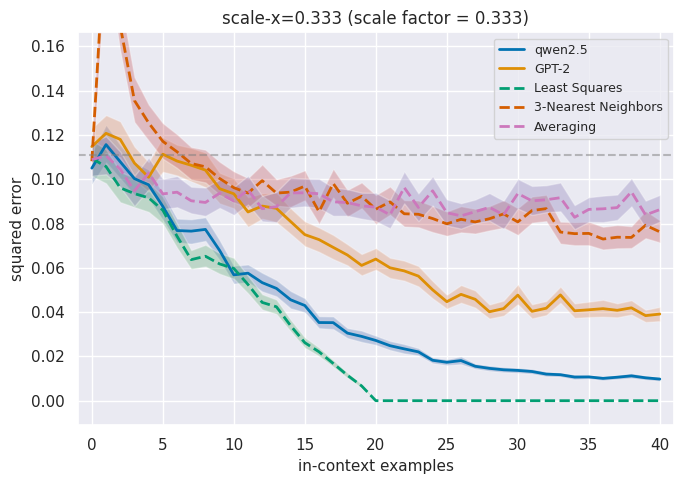

  ✓ scale-x=0.333: final loss = 0.20, y-range [0.00, 346.44]


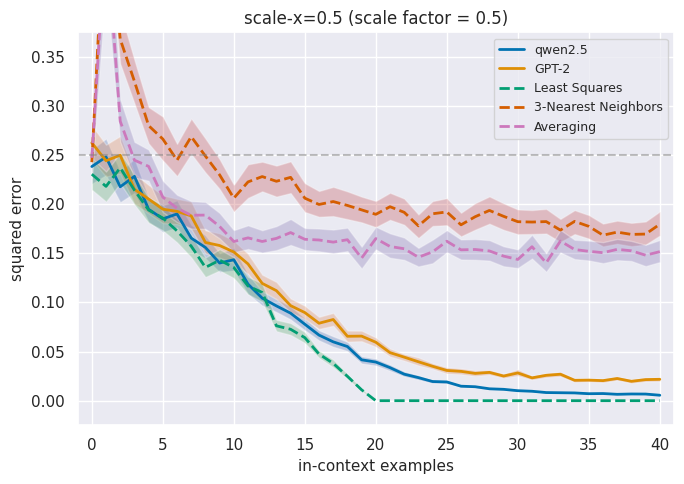

  ✓ scale-x=0.5: final loss = 0.11, y-range [0.00, 346.44]


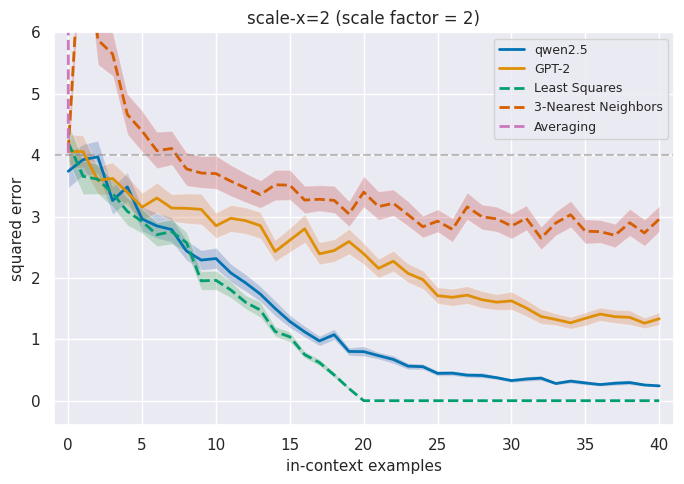

  ✓ scale-x=2: final loss = 4.83, y-range [0.00, 346.44]


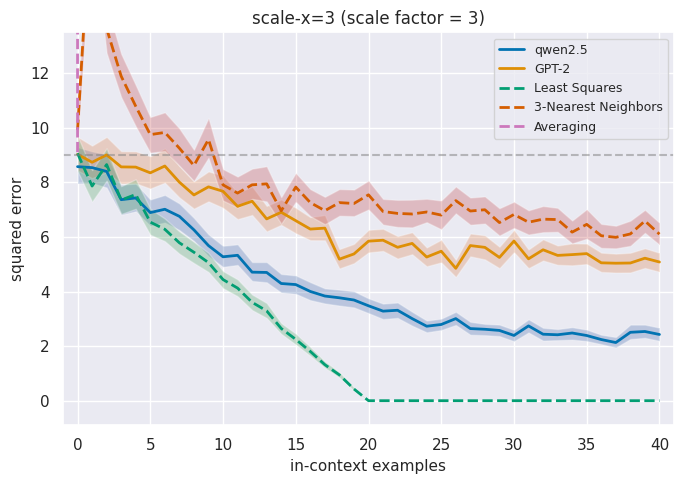

  ✓ scale-x=3: final loss = 48.54, y-range [0.00, 346.44]

Y-Scaling scenarios:


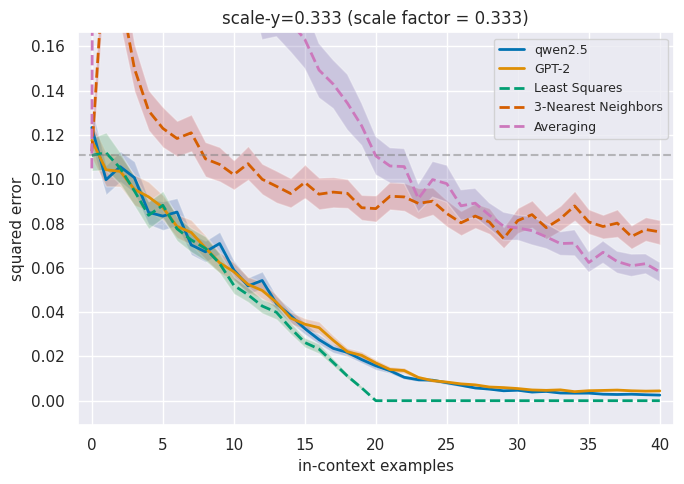

  ✓ scale-y=0.333: final loss = 0.05, y-range [0.00, 346.44]


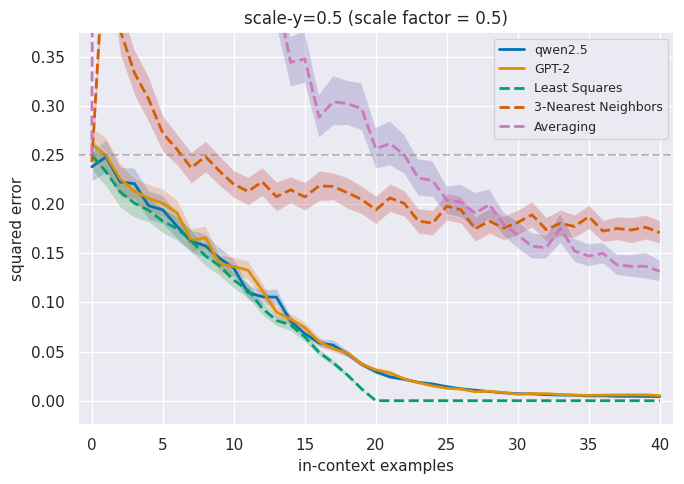

  ✓ scale-y=0.5: final loss = 0.08, y-range [0.00, 346.44]


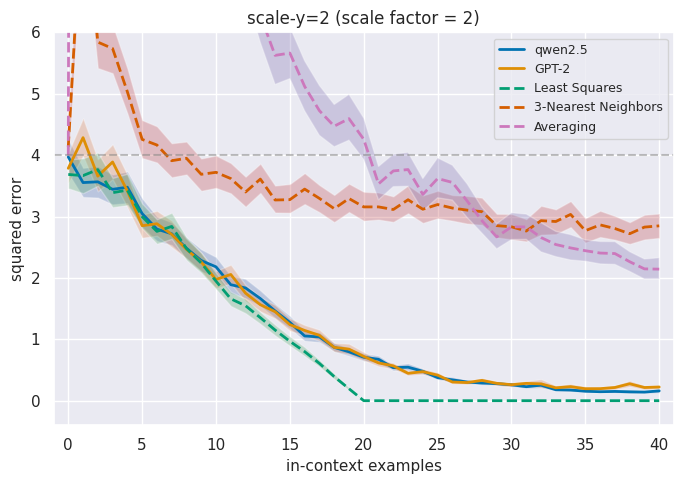

  ✓ scale-y=2: final loss = 3.19, y-range [0.00, 346.44]


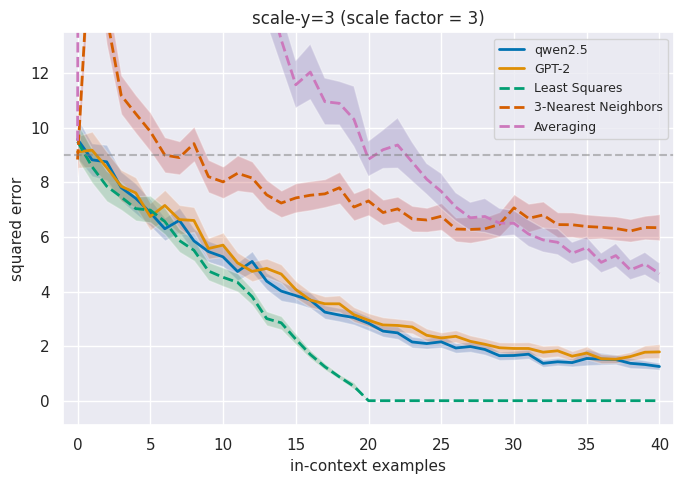

  ✓ scale-y=3: final loss = 25.03, y-range [0.00, 346.44]


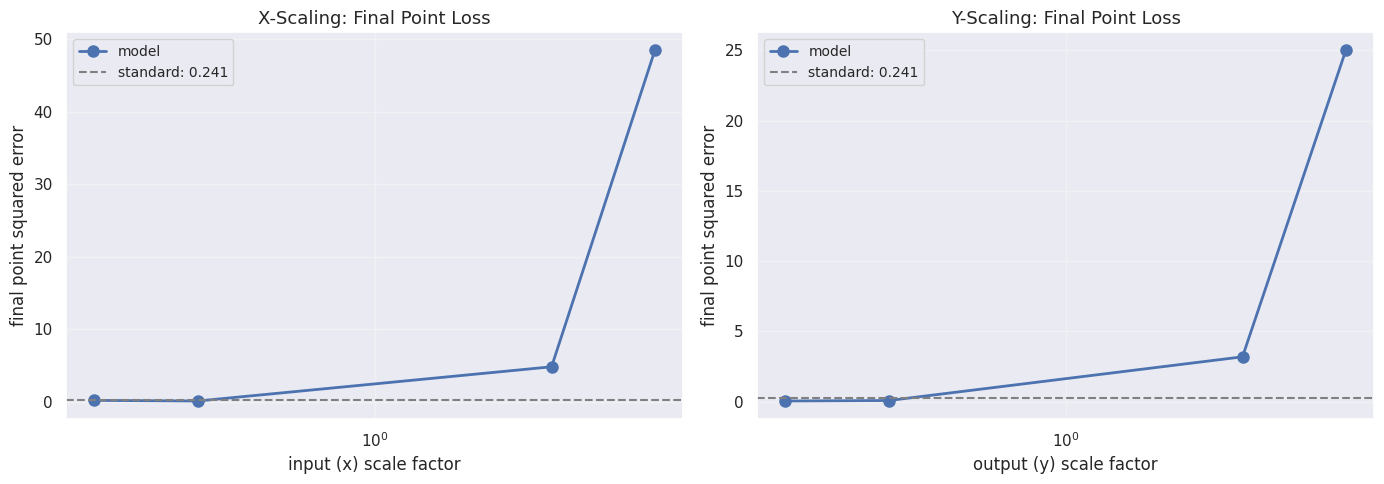


✓ Scaling summary plots completed


In [17]:
# Plot scaling tests individually
scales = [0.333, 0.5, 2, 3]

# Process and plot X-scaling
print("\nX-Scaling Robustness Tests:")
x_scaling_data = {}
for scale in scales:
    key = f"scale-x={scale}"
    if key in all_metrics and model_name in all_metrics[key]:
        x_scaling_data[scale] = {
            'final': all_metrics[key][model_name]["mean"][-1],
            'full': all_metrics[key][model_name]["mean"]
        }

# Process and plot Y-scaling
print("\nY-Scaling Robustness Tests:")
y_scaling_data = {}
for scale in scales:
    key = f"scale-y={scale}"
    if key in all_metrics and model_name in all_metrics[key]:
        y_scaling_data[scale] = {
            'final': all_metrics[key][model_name]["mean"][-1],
            'full': all_metrics[key][model_name]["mean"]
        }

# Plot each scaling scenario separately with proper axis limits
for dim, scaling_data in [('x', x_scaling_data), ('y', y_scaling_data)]:
    if not scaling_data:
        continue

    print(f"\n{dim.upper()}-Scaling scenarios:")

    for scale, data in sorted(scaling_data.items()):
        key = f"scale-{dim}={scale}"
        if key not in all_metrics:
            continue

        metric = all_metrics[key]

        # Create individual plot for each scale
        fig, ax = plt.subplots(figsize=(7, 5))

        colors = sns.color_palette('colorblind')
        all_values = []

        # Plot model
        if model_name in metric:
            # means = metric[model_name]["mean"]
            means = [m / normalization for m in metric[model_name]["mean"]]
            ax.plot(means, lw=2, label=f"{conf.model.family}", color=colors[0])
            all_values.extend(means)
            #
            low = [m / normalization for m in metric[model_name]["bootstrap_low"]]
            high = [m / normalization for m in metric[model_name]["bootstrap_high"]]
            ax.fill_between(range(len(low)), low, high, alpha=0.3)

        # Plot baselines
        for idx, baseline_key in enumerate(['gpt2_embd=256_layer=12_head=8', 'OLS_driver=None','NN_n=3_uniform', 'averaging'], 1):
            if baseline_key in metric:
                # means = metric[baseline_key]["mean"]
                means = [m / normalization for m in metric[baseline_key]["mean"]]
                label = baseline_labels_map.get(baseline_key, baseline_key)
                if label == 'GPT-2':
                    ax.plot(means, lw=2, label=label, color=colors[idx])
                else:
                    ax.plot(means, lw=2, label=label, linestyle='--', color=colors[idx])
                all_values.extend(means)
                #
                low = [m / normalization for m in metric[baseline_key]["bootstrap_low"]]
                high = [m / normalization for m in metric[baseline_key]["bootstrap_high"]]
                ax.fill_between(range(len(low)), low, high, alpha=0.3)

        # Add trivial baseline (scaled)
        trivial = scale**2 if dim == 'x' else scale**2
        ax.axhline(trivial, ls="--", color="gray", alpha=0.5)

        # Set title
        ax.set_title(f"{key} (scale factor = {scale})", fontsize=12)

        # Set yxis limits
        scale = float(key.split("=")[-1])**2
        ax.set_ylim(-.1 * scale, 1.5 * scale)

        ax.set_xlim(-1, len(metric[model_name]["mean"]))
        ax.set_xlabel("in-context examples", fontsize=11)
        ax.set_ylabel("squared error", fontsize=11)
        ax.legend(loc="best", fontsize=9)

        plt.tight_layout()

        plt.savefig(os.path.join("eval_figure",f"{key}.pdf"))
        plt.show()
        print(f"  ✓ {key}: final loss = {data['final']:.2f}, y-range [{y_min:.2f}, {y_max:.2f}]")

# Summary plot: final losses vs scale factor
if x_scaling_data or y_scaling_data:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # X-scaling summary
    if x_scaling_data:
        x_scales = sorted(x_scaling_data.keys())
        x_losses = [x_scaling_data[s]['final'] for s in x_scales]

        ax1.plot(x_scales, x_losses, lw=2, marker='o', markersize=8, label='model')
        if standard_loss:
            ax1.axhline(standard_loss, color='gray', linestyle='--',
                       label=f'standard: {standard_loss:.3f}')

        ax1.set_xlabel('input (x) scale factor', fontsize=12)
        ax1.set_ylabel('final point squared error', fontsize=12)
        ax1.set_title('X-Scaling: Final Point Loss', fontsize=13)
        ax1.set_xscale('log')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)

    # Y-scaling summary
    if y_scaling_data:
        y_scales = sorted(y_scaling_data.keys())
        y_losses = [y_scaling_data[s]['final'] for s in y_scales]

        ax2.plot(y_scales, y_losses, lw=2, marker='o', markersize=8, label='model')
        if standard_loss:
            ax2.axhline(standard_loss, color='gray', linestyle='--',
                       label=f'standard: {standard_loss:.3f}')

        ax2.set_xlabel('output (y) scale factor', fontsize=12)
        ax2.set_ylabel('final point squared error', fontsize=12)
        ax2.set_title('Y-Scaling: Final Point Loss', fontsize=13)
        ax2.set_xscale('log')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    plt.savefig(os.path.join("eval_figure", "scaling_summary.pdf"))
    plt.show()
    print("\n✓ Scaling summary plots completed")

